In [2]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
import torch

set_log_level(30)

In [3]:
g = 9.81
R = 287.0
T_gas = 300.0
L = 10.0
N = 200
T= 5.0

mesh = IntervalMesh(N, 0, L)


dx_cell = L / N
CFL = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

def two_phase_simulator(theta, T=10.0, N=200, L=10.0, seed=None, return_full=False):
    """
    theta: [C_wall_L, C_wall_G, C_int, theta_incline]
    Returns:
        (timesteps+1, N) array of alpha_L, or optionally all fields.
    """
    # Unpack
    C_wall_L, C_wall_G, C_int, theta_pipe, h_sed = theta

    rho_L = 800
    rho_G = 1.2

    if seed is not None:
        np.random.seed(seed)


    # Initial holdup and velocity profiles
    V = FunctionSpace(mesh, "DG", 0)
    x = SpatialCoordinate(mesh)
    alpha_L0 = project(0.5 + 0.15 * sin(2 * np.pi * x[0] / L), V)
    alpha_G0 = project(1.0 - (0.5 + 0.15 * sin(2 * np.pi * x[0] / L)), V)
        
    # if use_sediment:
    #     h_sed = 0.02

    C_wall_L_effective = C_wall_L * (1 + 150 * h_sed)

    u_L0 = 1.0 + .2 * np.sin(np.pi * cell_centers / L)
    u_G0 = 2.0 + .1 * np.cos(np.pi * cell_centers / L)

    dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
    timesteps = int(T / dt)

    alpha_L_n = Function(V)
    alpha_G_n = Function(V)
    alpha_L_n.assign(alpha_L0)
    alpha_G_n.assign(alpha_G0)
    u_L_n = u_L0.copy()
    u_G_n = u_G0.copy()

    all_data_L = np.zeros((timesteps+1, V.dim()))
    all_data_G = np.zeros((timesteps+1, V.dim()))
    all_data_uL = np.zeros((timesteps+1, V.dim()))
    all_data_uG = np.zeros((timesteps+1, V.dim()))
    all_data_L[0, :] = alpha_L_n.vector().get_local()
    all_data_G[0, :] = alpha_G_n.vector().get_local()
    all_data_uL[0, :] = u_L_n
    all_data_uG[0, :] = u_G_n

    def compute_geometries(alpha):
        r = max(0.01, 0.05 - h_sed)
        h_int = np.clip(r * (2 * alpha - 1), -r + 1e-8, r - 1e-8)
        r2 = r * r
        root_h = np.sqrt(r2 - h_int**2)
        A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
        A_G = r2 * np.arccos(h_int/r) - h_int * root_h
        P_LG = 2 * root_h
        P_LW = 2 * r * np.arccos(-h_int/r)
        P_GW = 2 * r * np.arccos(h_int/r)
        return h_int, A_L, A_G, P_LG, P_LW, P_GW

    for step in range(1, timesteps+1):
        alpha_L = alpha_L_n.vector().get_local()
        alpha_G = alpha_G_n.vector().get_local()
        u_L = u_L_n.copy()
        u_G = u_G_n.copy()

        # Geometry
        h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L)
        p_int = np.full_like(alpha_L, rho_G * R * T_gas)
        # Hydrostatic pressure (linear)
        p_av_L = p_int + rho_L * g * (h_int) * np.sin(theta_pipe)
        p_av_G = p_int + rho_G * g * (h_int) * np.sin(theta_pipe)
        # Pressure gradients
        p_grad_L = np.zeros_like(p_av_L)
        p_grad_G = np.zeros_like(p_av_G)
        p_grad_L[1:-1] = (p_av_L[2:] - p_av_L[:-2]) / (2 * dx_cell)
        p_grad_G[1:-1] = (p_av_G[2:] - p_av_G[:-2]) / (2 * dx_cell)
        p_grad_L[0] = (p_av_L[1] - p_av_L[0]) / dx_cell
        p_grad_L[-1] = (p_av_L[-1] - p_av_L[-2]) / dx_cell
        p_grad_G[0] = (p_av_G[1] - p_av_G[0]) / dx_cell
        p_grad_G[-1] = (p_av_G[-1] - p_av_G[-2]) / dx_cell

        # --- ADVECT HOLDUPS (Upwind FV) ---
        F_L = np.zeros_like(alpha_L)
        F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
        F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        F_L_left = np.zeros_like(alpha_L)
        F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
        F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

        F_G = np.zeros_like(alpha_G)
        F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
        F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        F_G_left = np.zeros_like(alpha_G)
        F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
        F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

        # --- MOMENTUM (Upwind FV + drag + pressure/grav) ---
        m_L = alpha_L * rho_L * u_L
        Fm_L = np.zeros_like(m_L)
        Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:] * rho_L
        Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        Fm_L_left = np.zeros_like(m_L)
        Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1] * rho_L
        Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        
        gravity_L = A_L * rho_L * g * np.sin(theta_pipe)
        m_L_new = m_L \
                  - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
                  - dt * C_wall_L_effective * m_L \
                  + dt * C_int * alpha_L * rho_L * (u_G - u_L) \
                  - dt * A_L * p_grad_L \
                  + dt * gravity_L
                  
        u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new * rho_L + 1e-12), 0.0)

        m_G = alpha_G * rho_G * u_G
        Fm_G = np.zeros_like(m_G)
        Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:] * rho_G
        Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G
        Fm_G_left = np.zeros_like(m_G)
        Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1] * rho_G
        Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G


        gravity_G = A_G * rho_G * g * np.sin(theta_pipe)

        m_G_new = m_G \
                  - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
                  - dt * C_wall_G * m_G \
                  - dt * C_int * alpha_G * rho_G * (u_G - u_L) \
                  - dt * A_G * p_grad_G \
                  + dt * gravity_G

        u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new * rho_G + 1e-12), 0.0)

        # --- ENFORCE CLOSURE ---
        sum_holdup = alpha_L_new + alpha_G_new
        alpha_L_new /= (sum_holdup + 1e-12)
        alpha_G_new /= (sum_holdup + 1e-12)

        # Save and update
        alpha_L_n.vector().set_local(alpha_L_new)
        alpha_G_n.vector().set_local(alpha_G_new)
        u_L_n = u_L_new
        u_G_n = u_G_new
        all_data_L[step, :] = alpha_L_new
        all_data_G[step, :] = alpha_G_new
        all_data_uL[step, :] = u_L_new
        all_data_uG[step, :] = u_G_new

    if return_full:
        return all_data_L, all_data_G, all_data_uL, all_data_uG, timesteps
    else:
        return all_data_L, timesteps

In [4]:
def fitness_func(theta_candidate):
    sim_alpha_L, _ = two_phase_simulator(theta_candidate, T=5.0, N=200, L=10.0, seed=123, return_full=False)
    # Compare only the final time, or over all times and cells
    error = np.mean((sim_alpha_L - alpha_L_obs)**2)
    return -error  # pygad maximizes fitness, so use negative error

In [5]:
gene_space = [
    {'low': 0.5, 'high': 1.0},  # C_wall_L
    {'low': 0.2, 'high': 1.0},  # C_wall_G
    {'low': 0.1, 'high': 0.4},  # C_int
    {'low': 0.0, 'high': np.pi/2},  # theta_incline
    {'low': 0.0, 'high': 0.05},  # h_sed
]

In [13]:
import pygad

theta_true = [0.8155, 0.6099, 0.2382, 0.3897, 0.02]
# alpha_L_obs should be generated with theta_true as input, or real data
alpha_L_obs, _ = two_phase_simulator(theta_true, T=5.0, N=200, L=10.0, seed=123, return_full=False)

def fitness_func(ga_instance, solution, solution_idx):
    sim_alpha_L, _ = two_phase_simulator(solution, T=5.0, N=200, L=10.0, seed=123, return_full=False)
    error = np.mean((sim_alpha_L - alpha_L_obs)**2)
    return -error

ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=20,
    num_genes=5,
    gene_space=gene_space,
    mutation_percent_genes=50,
    mutation_type="random",
    crossover_type="single_point",
    allow_duplicate_genes=False,
    random_mutation_min_val=-0.01,
    random_mutation_max_val=0.01,
    stop_criteria="saturate_20"
)

ga_instance.run()
print("Best solution: ", ga_instance.best_solution())


Best solution:  (array([0.71291515, 0.60146934, 0.24810553, 0.66889266, 0.02468425]), np.float64(-6.357433184974452e-08), np.int64(0))


In [15]:
# this took 7m 19.7s
solution, solution_fitness, _ = ga_instance.best_solution()

In [16]:
print(f"Estimated parameters: {solution}")
print(f"True parameters:      {theta_true}")
print(f"Fitness (MSE):       {-solution_fitness}")

Estimated parameters: [0.71291515 0.60146934 0.24810553 0.66889266 0.02468425]
True parameters:      [0.8155, 0.6099, 0.2382, 0.3897, 0.02]
Fitness (MSE):       6.357433184974452e-08


/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


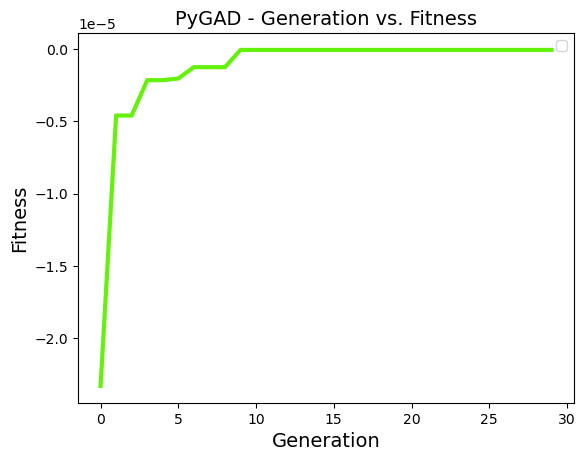

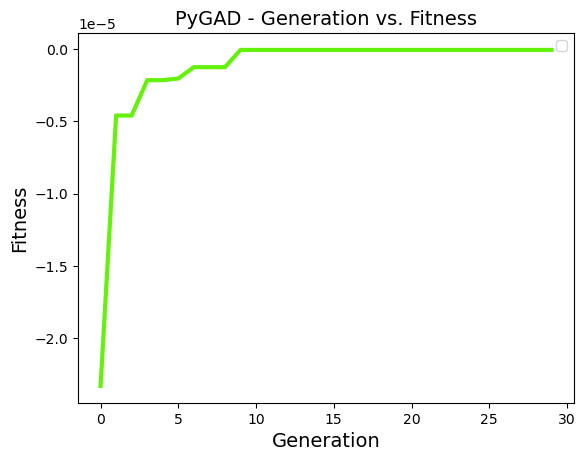

In [17]:
ga_instance.plot_fitness()